## École Polytechnique de Montréal
## Département Génie Informatique et Génie Logiciel

## INF8460 – Traitement automatique de la langue naturelle - TP1

## Objectifs d'apprentissage: 

•	Savoir accéder à un corpus, le nettoyer et effectuer divers pré-traitements sur les données
•	Savoir effectuer une classification automatique des textes pour l’analyse de sentiments
•	Evaluer l’impact des pré-traitements sur les résultats obtenus


## Équipe et contributions 
Veuillez indiquer la contribution effective de chaque membre de l'équipe en pourcentage et en indiquant les modules ou questions sur lesquelles chaque membre a travaillé


Cedric Sadeu: x% (détail)

Mamoudou Sacko: x% (détail)

Oumayma Messoussi: x% (détail)

## Librairies externes

In [72]:
import os
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import display
from typing import List, Literal, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import tokenize
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oumay\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oumay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oumay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Valeurs globales

In [2]:
data_path = "data"
output_path = "output"

## Données

In [3]:
def read_data(path: str) -> Tuple[List[str], List[bool], List[Literal["M", "W"]]]:
    data = pd.read_csv(path)
    inputs = data["response_text"].tolist()
    labels = (data["sentiment"] == "Positive").tolist()
    gender = data["op_gender"].tolist()
    return inputs, labels, gender

In [4]:
train_data = read_data(os.path.join(data_path, "train.csv"))
test_data = read_data(os.path.join(data_path, "test.csv"))

train_data = ([text.lower() for text in train_data[0]], train_data[1], train_data[2])
test_data = ([text.lower() for text in test_data[0]], test_data[1], test_data[2])

print("train data line 0: \n\t- response_text: " + str(train_data[0][0]) 
      + "\n\t- sentiment: " + str(train_data[1][0]) + "\n\t- gender: " + str(train_data[2][0]))

train data line 0: 
	- response_text: i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor.
	- sentiment: False
	- gender: M


## 1. Pré-traitement et Exploration des données

### Lecture et prétraitement

Dans cette section, vous devez compléter la fonction preprocess_corpus qui doit être appelée sur les fichiers train.csv et test.csv. La fonction preprocess_corpus appellera les différentes fonctions créées ci-dessous. Les différents fichiers de sortie doivent se retrouver dans le répertoire output.  Chacune des sous-questions suivantes devraient être une ou plusieurs fonctions.

In [5]:
def write_to_csv(sentences, corpus_name):
    dt = pd.DataFrame(sentences, columns =['sentences'])
    dt.to_csv(corpus_name + '.csv')

def write_corpus_to_csv(corpus, corpus_name):
    sentences = []
    for doc in corpus:
        sentences.extend(doc[1])
    write_to_csv(sentences, corpus_name)

def process_list_corpus_tup(func, corpus_tup_list):
    process_corpus = []
    for doc in corpus_tup_list:
        result = (doc[0], func(doc[1]), doc[2])
        process_corpus.append(result)
    return process_corpus

#### 1) Segmentez chaque corpus en phrases, et stockez-les dans un fichier `nomcorpus`_phrases.csv (une phrase par ligne)

In [6]:
def make_sentence(line):
    sentences = tokenize.sent_tokenize(line)
    return [sentence for sentence in sentences if re.findall(r"[\w]+", sentence)]


def corpus_to_sentences(data):  
    #check data is not empty and lists inside data have the same length
    if (not data) or [len(element) for element in data if len(element) != len(data[0])]:
        raise ValueError("Data is not valid.")
    vocabulary = []
    for i, item in enumerate(data[0]):
        document = (data[2][i], make_sentence(item), data[1][i])
        vocabulary.append(document)
    
    return vocabulary

In [7]:
print((train_data[0][0:5], train_data[1][0:5], train_data[2][0:5]))
print(corpus_to_sentences((train_data[0][0:5], train_data[1][0:5], train_data[2][0:5])))

(["i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor.", ";-)...anything other than jeans and t-shirts are superfluous, by the way. 'update your wardrobe'...pfft.", 'meh, i could only get to 8. need to work up.', 'a bill consisting of a single sentence. very well done, sir.', 'so far, so good. thx !'], [False, False, False, True, True], ['M', 'M', 'M', 'M', 'W'])
[('M', ["i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor."], False), ('M', [';-)...anything other than jeans and t-shirts are superfluous, by the way.', "'update your wardrobe'...pfft."], False), ('M', ['meh, i could only get to 8. need to work up.'], False), ('M', ['a bill consisting of a single sentence.', 'very well done, sir.'], True), ('W', ['so far, so good.', 'thx !'], True)]


#### 2) Normalisez chaque corpus au moyen d’expressions régulières en annotant les négations avec _Neg L’annotation de la négation doit ajouter un suffixe _NEG à chaque mot qui apparait entre une négation et un signe de ponctuation qui identifie une clause. Exemple : 
No one enjoys it.  no one_NEG enjoys_NEG it_NEG .
I don’t think I will enjoy it, but I might.  i don’t think_NEG i_NEG will_NEG enjoy_NEG it_NEG, but i might.

In [8]:
def normalise_doc(doc):
    normalised_doc = []
    for sentence in doc:
        normalised = re.sub(r"""(n't|\b(?:never|no|nothing|nowhere|noone|none|not|
                havent|hasnt|hadnt|cant|couldnt|shouldnt|
                wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint))\b[\w\s]+[^\w\s]""", lambda match: re.sub(r'(\s+)(\w+)', r'\1\2_NEG', match.group(0)), sentence, flags=re.IGNORECASE)
        normalised_doc.append(normalised)
    return normalised_doc

In [9]:
normalise_doc(train_data[0][0:25])

["i don't think_NEG any_NEG one_NEG there_NEG has_NEG ebola_NEG bob_NEG latta_NEG you_NEG should_NEG be_NEG back_NEG in_NEG washington_NEG actually_NEG getting_NEG something_NEG done_NEG there_NEG on_NEG the_NEG house_NEG floor_NEG.",
 ";-)...anything other than jeans and t-shirts are superfluous, by the way. 'update your wardrobe'...pfft.",
 'meh, i could only get to 8. need to work up.',
 'a bill consisting of a single sentence. very well done, sir.',
 'so far, so good. thx !',
 'my buddy jeff johnson was your prop master on that.',
 'she had me at everlasting youth.',
 'congratulations to you for a well deserved recognition!',
 'baffoon, idiot, dumb. the intelegent conversation continues.......',
 "they don't deserve_NEG that_NEG honour_NEG(stupid hollywood movie business people)",
 'yawn! is this honestly news?',
 'same to you brotha! get at it :)',
 'would good to know how the age of all of these things have been measured.',
 'the perfect society is shaped in the form of a pyramid

#### 3) Segmentez chaque phrase en mots (tokenisation) et stockez-les dans un fichier `nomcorpus`_mots.csv. (Une phrase par ligne, chaque token séparé par un espace, il n’est pas nécessaire de stocker la phrase non segmentée ici) ;

In [10]:
def tokenize_sentence(sentence):
    return regexp_tokenize(sentence, "[\w']+")

def tokenize_doc(doc):
    results = []
    for sentence in doc:
        tokens = tokenize_sentence(sentence)
        results.append(" ".join(tokens))
    return results

In [11]:
tokenize_doc(train_data[0][0:2])

["i don't think any one there has ebola bob latta you should be back in washington actually getting something done there on the house floor",
 "anything other than jeans and t shirts are superfluous by the way 'update your wardrobe' pfft"]

#### 4) Lemmatisez les mots et stockez les lemmes dans un fichier `nomcorpus`_lemmes.csv (une phrase par ligne, les lemmes séparés par un espace) ;

In [12]:
def lemmatisation_sentence(wordList):
    lemmatizer = WordNetLemmatizer()
    word_tuples = nltk.pos_tag(wordList)
    results = []
    for word, tag in word_tuples:
        if tag[0].lower() in ['a', 'r', 'n', 'v']:
            word = word.lower()
            if '_neg' in word:
                word = word.replace('_neg', '')
                lemme = lemmatizer.lemmatize(word, tag[0].lower())
                lemme = lemme + '_NEG'
                results.append(lemme)
            else:
                results.append(lemmatizer.lemmatize(word, tag[0].lower()))
        else:
            results.append(word)
    return results

def lemmatize_doc(doc):
    results = []
    for line in doc:
        lemmas = lemmatisation_sentence(re.split(r'\s', line))
        results.append(" ".join(lemmas))
    return results

In [13]:
print(normalise_doc(train_data[0][0:5]))
print(lemmatize_doc(tokenize_doc(normalise_doc(train_data[0][0:5]))))

["i don't think_NEG any_NEG one_NEG there_NEG has_NEG ebola_NEG bob_NEG latta_NEG you_NEG should_NEG be_NEG back_NEG in_NEG washington_NEG actually_NEG getting_NEG something_NEG done_NEG there_NEG on_NEG the_NEG house_NEG floor_NEG.", ";-)...anything other than jeans and t-shirts are superfluous, by the way. 'update your wardrobe'...pfft.", 'meh, i could only get to 8. need to work up.', 'a bill consisting of a single sentence. very well done, sir.', 'so far, so good. thx !']
["i don't think_NEG any_NEG one_NEG there_NEG ha_NEG ebola_NEG bob_NEG latta_NEG you_NEG should_NEG be_NEG back_NEG in_NEG washington_NEG actually_NEG getting_NEG something_NEG done_NEG there_NEG on_NEG the_NEG house_NEG floor_NEG", "anything other than jean and t shirt be superfluous by the way 'update your wardrobe' pfft", 'meh i could only get to 8 need to work up', 'a bill consist of a single sentence very well do sir', 'so far so good thx']


#### 5) Retrouvez la racine des mots (stemming) en utilisant nltk.PorterStemmer(). Stockez-les dans un fichier `nomcorpus`_stems.csv (une phrase par ligne, les racines séparées par une espace) ;

In [14]:
def stemming_sentence(wordList):
    stemmer = PorterStemmer()
    result = []
    for word in wordList:
        word = word.lower()
        if '_neg' in word:
            word = word.replace('_neg', '')
            stem = stemmer.stem(word)
            stem = stem + '_NEG'
            result.append(stem)
        else:
            result.append(stemmer.stem(word))
    return result

def stems_doc(doc):
    results = []
    for line in doc:
        stems = stemming_sentence(re.split(r'\s', line))
        results.append(" ".join(stems))
    return results

In [15]:
print(normalise_doc(train_data[0][0:5]))
print(stems_doc(tokenize_doc(normalise_doc(train_data[0][0:5]))))

["i don't think_NEG any_NEG one_NEG there_NEG has_NEG ebola_NEG bob_NEG latta_NEG you_NEG should_NEG be_NEG back_NEG in_NEG washington_NEG actually_NEG getting_NEG something_NEG done_NEG there_NEG on_NEG the_NEG house_NEG floor_NEG.", ";-)...anything other than jeans and t-shirts are superfluous, by the way. 'update your wardrobe'...pfft.", 'meh, i could only get to 8. need to work up.', 'a bill consisting of a single sentence. very well done, sir.', 'so far, so good. thx !']
["i don't think_NEG ani_NEG one_NEG there_NEG ha_NEG ebola_NEG bob_NEG latta_NEG you_NEG should_NEG be_NEG back_NEG in_NEG washington_NEG actual_NEG get_NEG someth_NEG done_NEG there_NEG on_NEG the_NEG hous_NEG floor_NEG", "anyth other than jean and t shirt are superflu by the way 'updat your wardrobe' pfft", 'meh i could onli get to 8 need to work up', 'a bill consist of a singl sentenc veri well done sir', 'so far so good thx']


#### 6) Ecrivez une fonction qui supprime les mots outils (stopwords) du corpus. Vous devez utiliser la liste de stopwords de NLTK ;

In [16]:
def remove_stopwords_wordList(wordList):
    stop_words = set(stopwords.words('english'))
    return [word for word in wordList if word.replace("_NEG", "").isalnum() and word.replace("_NEG", "") not in stop_words] 

def remove_stopwords_doc(doc):
    results = []
    for line in doc:
        clean_line = remove_stopwords_wordList(re.split(r'\s', line))
        results.append(" ".join(clean_line))
    return results

In [17]:
remove_stopwords_doc(tokenize_doc(normalise_doc(train_data[0][0:5])))

['think_NEG one_NEG ebola_NEG bob_NEG latta_NEG back_NEG washington_NEG actually_NEG getting_NEG something_NEG done_NEG house_NEG floor_NEG',
 'anything jeans shirts superfluous way pfft',
 'meh could get 8 need work',
 'bill consisting single sentence well done sir',
 'far good thx']

#### 7) Écrivez une fonction preprocess_corpus(corpus) qui prend un corpus brut stocké dans un fichier.csv, effectue les étapes précédentes, puis stocke le résultat de ces différentes opérations dans un fichier corpus _norm.csv

In [18]:
def preprocess_corpus(input_file: str, output_file: str) -> None:
    matches  = re.findall(r"\w+_norm.csv$", output_file)
    if matches:
        output_file = matches[0].split("_norm.csv")[0]
    output_file += "/train" if "train" in input_file else "/test"
    
    train_data = read_data(input_file)
    
    corpus = corpus_to_sentences(train_data)
    write_corpus_to_csv(corpus, output_file + '_phrases')

    normalised_corpus = process_list_corpus_tup(normalise_doc, corpus)
    write_corpus_to_csv(normalised_corpus, output_file + '_normalised')

    #tokenized_corpus = process_dict_corpus(tokenize_doc, normalised_corpus)
    tokenized_corpus = process_list_corpus_tup(tokenize_doc, corpus)
    write_corpus_to_csv(tokenized_corpus, output_file + '_mots')
    #print(tokenized_corpus)

#     lemmatized_corpus = process_list_corpus_tup(lemmatize_doc, tokenized_corpus)
#     write_corpus_to_csv(lemmatized_corpus, output_file + '_lemmes')
#     #print(lemmatized_corpus)

    stemmed_corpus = process_list_corpus_tup(stems_doc, tokenized_corpus)
    write_corpus_to_csv(stemmed_corpus, output_file + '_stems')
    #print(stemmed_corpus)

    removed_stopwords_corpus = process_list_corpus_tup(remove_stopwords_doc, stemmed_corpus)
    write_corpus_to_csv(removed_stopwords_corpus, output_file + '_norm')
    #print(removed_stopwords_corpus)

In [19]:
preprocess_corpus(os.path.join(data_path, "train.csv"), os.path.join(output_path))

preprocess_corpus(os.path.join(data_path, "test.csv"), os.path.join(output_path))

### Exploration des données

#### 1)

Complétez les fonctions retournant les informations suivantes (une fonction par information, chaque fonction prenant en argument un corpus composé d'une liste de phrases segmentées en tokens(tokenization)) ou une liste de genres et une liste de sentiments:

In [20]:
# Synthetic corpus for quick testing
corpus = [ ("M", ["I am home_NEG", "You are late_NEG", "He is fine"], "N" ),
           ("W", ["let's go home_NEG", "I'm happy"], "P" ),
           ("M", ["You are alone"], "N" ) ]

# Helper function
def get_distinct_number(data: List[object]) -> int:

    unique_list = []
    for sentence in data: 
        for word in sentence:
            if word not in unique_list: 
                unique_list.append(word) 

    return len(unique_list)

##### a. Le nombre total de tokens (mots non distincts)

In [21]:
def total_tokens(corpus: List[object]) -> int:
    total = 0
    for doc in corpus:
        for sentence in doc[1]:
            total += len(sentence.split())
    return total

##### b. Le nombre total de types

In [22]:
def total_types(corpus: List[object]) -> int:
    types = []
    for doc in corpus:
        for sentence in doc[1]:
            for word in sentence.split():
                types.append(word)
    return len(set(types))

##### c. Le nombre total de phrases avec négation

In [23]:
def total_neg(corpus: List[object]) -> int:
    total = 0
    for doc in corpus:
        for sentence in doc[1]:
            if "_NEG" in sentence:
                total += 1
    return total

##### d. Le ratio token/type

In [24]:
def TTR(corpus: List[object]) -> int:
    return total_tokens(corpus) / total_types(corpus)

##### e. Le nombre total de lemmes distincts

In [25]:
def get_lem_count(corpus: List[object]) -> int: # corpus already lemmatized
    return get_distinct_number(corpus)

##### f. Le nombre total de racines (stems) distinctes

In [26]:
def get_stem_count(corpus: List[object]) -> int: # corpus already stemmed
    return get_distinct_number(corpus)

##### g. Le nombre total de documents (par classe)

In [27]:
def get_documents_count(corpus: List[object]) -> object:
    result = {}
    for doc in corpus: 
        sentiment = doc[2]
        if sentiment in result:
            result[sentiment] += 1
        else:
            result.setdefault(sentiment, 1)

    return result

##### h. Le nombre total de phrases (par classe)

In [28]:
def get_sentences_count(corpus: List[object]) -> object:
    result = {}
    for doc in corpus: 
        sentiment = doc[2]
        sentences = doc[1]
        if sentiment in result:
            result[sentiment] += len(sentences)
        else:
            result.setdefault(sentiment, len(sentences))

    return result

##### i. Le nombre total de phrases avec négation (par classe)

In [29]:
def get_sentences_neg_count(corpus: List[object]) -> object:
    result = {}
    for doc in corpus: 
        sentiment = doc[2]
        sentences_neg = [sentence for sentence in doc[1] if sentence.find("_NEG") >= 0]
        if sentiment in result:
            result[sentiment] += len(sentences_neg)
        else:
            result.setdefault(sentiment, len(sentences_neg))

    return result

##### j. Le pourcentage de réponses positives par genre de la personne à qui cette réponse est faite (op_gender)

In [30]:
def get_positive_answers(corpus: List[object]) -> object:
    result = {"M": 0, "W": 0}
    for doc in corpus: 
        sentiment = doc[2]
        genre = doc[0]
        if sentiment:
            if genre in result:
                result[genre] += 1
            else:
                result.setdefault(genre, 1)

    response = {}
    response["M"] = str((result["M"] / (result["M"]+result["W"])) * 100) + "%"  # result["M"]+result["W"] ?
    response["W"] = str((result["W"] / (result["M"]+result["W"])) * 100) + "%"
    return response

#### 2) Écrivez la fonction explore(corpus, sentiments, genders) qui calcule et affiche toutes ces informations, précédées d'une légende reprenant l’énoncé de chaque question (a,b, ….j).

In [31]:
def explore(corpus: List[object]) -> None:
    normalised_corpus = process_list_corpus_tup(normalise_doc, corpus)
    tokenized_corpus = process_list_corpus_tup(tokenize_doc, corpus)
    lemmatized_corpus = process_list_corpus_tup(lemmatize_doc, tokenized_corpus)
    stemmed_corpus = process_list_corpus_tup(stems_doc, tokenized_corpus)
    
    print("a. Le nombre total de tokens (mots non distincts)")
    display(total_tokens(corpus))
    print("\nb. Le nombre total de types")
    display(total_types(corpus))
    print("\nc. Le nombre total de phrases avec négation")
    display(total_neg(normalised_corpus))
    print("\nd. Le ratio token/type")
    display(TTR(corpus))
    print("\ne. Le nombre total de lemmes distincts")
    display(get_lem_count(lemmatized_corpus))
    print("\nf. Le nombre total de racines (stems) distinctes")
    display(get_stem_count(stemmed_corpus))
    print("\ng. Le nombre total de documents (par classe)")
    display(get_documents_count(corpus))
    print("\nh. Le nombre total de phrases (par classe)")
    display(get_sentences_count(corpus))
    print("\ni. Le nombre total de phrases avec négation (par classe)")
    display(get_sentences_neg_count(normalised_corpus))
    print("\nj. Le pourcentage de réponses positives par genre de la personne à qui cette réponse est faite (op_gender)")
    display(get_positive_answers(corpus))

In [32]:
train_data = read_data(os.path.join(data_path, "train.csv"))
corpus = corpus_to_sentences(train_data)

explore(corpus)

a. Le nombre total de tokens (mots non distincts)


154680


b. Le nombre total de types


26769


c. Le nombre total de phrases avec négation


1895


d. Le ratio token/type


5.778325675221338


e. Le nombre total de lemmes distincts


8685


f. Le nombre total de racines (stems) distinctes


8680


g. Le nombre total de documents (par classe)


{False: 2285, True: 6756}


h. Le nombre total de phrases (par classe)


{False: 4302, True: 13109}


i. Le nombre total de phrases avec négation (par classe)


{False: 890, True: 1005}


j. Le pourcentage de réponses positives par genre de la personne à qui cette réponse est faite (op_gender)


{'M': '47.335701598579035%', 'W': '52.664298401420965%'}

#### 3) Calculer une table de fréquence (lemme, rang (le mot le plus fréquent a le rang 1 etc.) ; fréquence (le nombre de fois où il a été vu dans le corpus).  Seuls les N mots les plus fréquents du vocabulaire (N est un paramètre) doivent être gardés. Vous devez stocker les 1000 premières lignes de cette table dans un fichier nommé table_freq.csv

In [33]:
def count_words(doc, vocabulary_dict):
    #vocabulary_dict = {}
    for line in doc:
        words_list = re.split(r'\s', line)
        for word in words_list:
            if word in vocabulary_dict:
                vocabulary_dict[word] += 1
            else:
                vocabulary_dict.setdefault(word, 1)
    return vocabulary_dict

def count_words_corpus(corpus):
    vocabulary_dict = {}
    for doc in corpus:
        vocabulary_dict = count_words(doc[1], vocabulary_dict) 
    return vocabulary_dict


def frequence_table_corpus(tokenized_corpus, N):
    dict_word = count_words_corpus(tokenized_corpus)
    result = sorted(dict_word.items(), key=lambda x: x[1], reverse=True)
    if len(result) > N:
        result = result[0:N]
    return result

def write_frequence_to_csv(tup_list):
    result = list(zip(*tup_list))
    rang = range(1, len(result[1])+1)
    dict_result = {"word" : result[0], "frequence" : result[1], "rang":  rang}
    dt = pd.DataFrame(dict_result)
    dt.to_csv('table_freq.csv')
    
def display_freq_table(tup_list):
    result = list(zip(*tup_list))
    rang = range(1, len(result[1])+1)
    dict_result = {"word" : result[0], "frequence" : result[1], "rang":  rang}
    dt = pd.DataFrame(dict_result)
    display(dt)

In [34]:
train_data = read_data(os.path.join(data_path, "train.csv"))
corpus = corpus_to_sentences(train_data)
tokenized_corpus = process_list_corpus_tup(tokenize_doc, corpus)

result = frequence_table_corpus(tokenized_corpus, 1000)
display_freq_table(result)

write_frequence_to_csv(result)

,word,frequence,rang
0,the,5043,1
1,to,4256,2
2,I,3398,3
3,you,3349,4
4,and,3253,5
...,...,...,...
995,lead,17,996
996,Amen,17,997
997,attention,17,998
998,politicians,17,999


## 2. Classification automatique

### a) Classification  automatique avec un modèle sac de mots (unigrammes), Naive Bayes et la régression logistique

En utilisant la librairie scikitLearn et l’algorithme Multinomial Naive Bayes et Logistic Regression, effectuez la classification des textes avec un modèle sac de mots unigramme pondéré avec TF-IDF.  Vous devez entrainer chaque modèle sur l’ensemble d’entrainement et le construire à partir de votre fichier corpus_train.csv. 

Construisez et sauvegardez votre modèle sac de mots avec les données d’entrainement en testant les pré-traitements suivants (séparément et en combinaison): tokenisation, lemmatisation, stemming, normalisation des négations, et suppression des mots outils. Vous ne devez garder que la combinaison d’opérations qui vous donne les meilleures performances sur le corpus de test. Indiquez dans un commentaire les pré-traitements qui vous amènent à votre meilleure performance (voir la section 3 – évaluation). Il est possible que la combinaison optimale ne soit pas la même selon que vous utilisiez la régression logistique ou Naive Bayes. On s’attend à avoir deux modèles optimaux, un pour Naive Bayes, et un avec régression logistique.

In [35]:
def combinations_maker(process_list):
    tuple_list = []
    for i, _ in enumerate(process_list):
        if i == 2:
            break
        tuple_list.extend(list(combinations(process_list, i+1)))
    return [item for item in tuple_list if item != (lemmatize_doc, stems_doc) and item !=  (stems_doc, lemmatize_doc)]


def combinations_process_corpus(process_list, tokenized_corpus):
    result = []
    comb_process_list = combinations_maker(process_list)
    for comb in comb_process_list:
        corpus = tokenized_corpus
        for func in comb:
            corpus = process_list_corpus_tup(func, corpus)
        result.append((corpus, tuple(i.__name__ for i in comb)))
    return result

### Sac de mots + TF-IDF

In [36]:
process_list = [lemmatize_doc, stems_doc, remove_stopwords_doc]

train_data = read_data(os.path.join(data_path, "train.csv"))
corpus = corpus_to_sentences(train_data)
normalised_corpus = process_list_corpus_tup(normalise_doc, corpus)
tokenized_corpus = process_list_corpus_tup(tokenize_doc, corpus)

combinations_result = combinations_process_corpus(process_list, tokenized_corpus)

In [37]:
test_data = read_data(os.path.join(data_path, "test.csv"))
corpus = corpus_to_sentences(test_data)
normalised_corpus = process_list_corpus_tup(normalise_doc, corpus)
tokenized_corpus = process_list_corpus_tup(tokenize_doc, corpus)

test_combinations_result = combinations_process_corpus(process_list, tokenized_corpus)

In [50]:
X_train, y_train, X_test, y_test, X_train_tfidf, X_test_tfidf, combination_names = [], [], [], [], [], [], []

for comb in range(len(combinations_result)):
    combination_name = combinations_result[comb][1]
    combination_names.append(', '.join(combination_name))
    print("\nCombination "+str(comb)+": "+combination_names[comb])
    
    X_train.append([combinations_result[comb][0][i][1] for i in range(len(combinations_result[comb][0]))])
    y_train.append([combinations_result[comb][0][i][2] for i in range(len(combinations_result[comb][0]))])
    X_train[comb] = [' '.join(doc) for doc in X_train[comb]]
    
    X_test.append([test_combinations_result[comb][0][i][1] for i in range(len(test_combinations_result[comb][0]))])
    y_test.append([test_combinations_result[comb][0][i][2] for i in range(len(test_combinations_result[comb][0]))])
    X_test[comb] = [' '.join(doc) for doc in X_test[comb]]

    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf.append(tfidf_vectorizer.fit_transform(X_train[comb]).toarray())
    X_test_tfidf.append(tfidf_vectorizer.transform(X_test[comb]))
    print(X_train_tfidf[comb].shape)
    print(X_test_tfidf[comb].shape)

# print(len([' '.join(doc) for doc in [combinations_result[0][0][i][1] for i in range(len(combinations_result[0][0]))]]))


Combination 0: lemmatize_doc
(9041, 12387)
(1005, 12387)

Combination 1: stems_doc
(9041, 10948)
(1005, 10948)

Combination 2: remove_stopwords_doc
(9041, 14332)
(1005, 14332)

Combination 3: lemmatize_doc, remove_stopwords_doc
(9041, 12141)
(1005, 12141)

Combination 4: stems_doc, remove_stopwords_doc
(9041, 10598)
(1005, 10598)


### Naive Bayes


Combination 0: lemmatize_doc
              precision    recall  f1-score   support

           N       0.93      0.11      0.20       254
           P       0.77      1.00      0.87       751

    accuracy                           0.77      1005
   macro avg       0.85      0.55      0.53      1005
weighted avg       0.81      0.77      0.70      1005

0.7731343283582089
[[ 28 226]
 [  2 749]]

Combination 1: stems_doc
              precision    recall  f1-score   support

           N       0.83      0.11      0.20       254
           P       0.77      0.99      0.87       751

    accuracy                           0.77      1005
   macro avg       0.80      0.55      0.53      1005
weighted avg       0.78      0.77      0.70      1005

0.7701492537313432
[[ 29 225]
 [  6 745]]

Combination 2: remove_stopwords_doc
              precision    recall  f1-score   support

           N       0.87      0.15      0.26       254
           P       0.78      0.99      0.87       751

    a

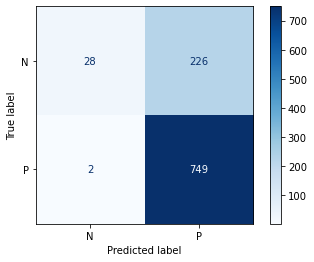

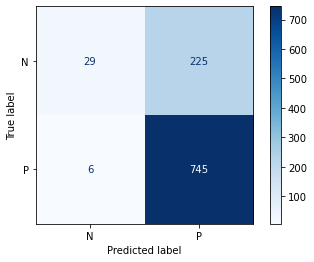

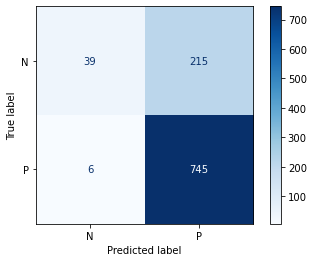

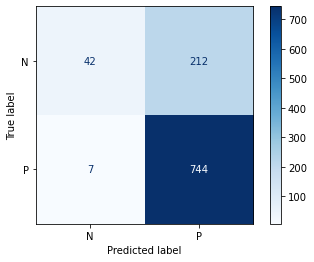

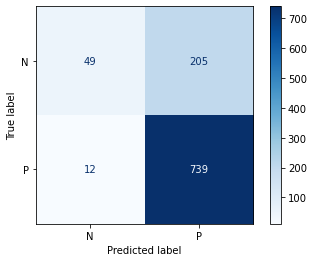

In [75]:
y_pred = []

for i in range(len(X_train_tfidf)):
    model = MultinomialNB()
    model.fit(X_train_tfidf[i], y_train[i])

    y_pred.append(model.predict(X_test_tfidf[i]))
    
    print("\nCombination "+str(i)+": "+combination_names[i])
    print(classification_report(y_test[i], y_pred[i], target_names=["N", "P"]))
    print(accuracy_score(y_test[i], y_pred[i]))
    print(confusion_matrix(y_test[i], y_pred[i]))
    plot_confusion_matrix(model, X_test_tfidf[i], y_test[i],
                                 display_labels=["N", "P"],
                                 cmap=plt.cm.Blues)
    
    with open('NaiveBayes_tfidf_'+combination_names[i].replace(', ', '_'), 'wb') as picklefile:
        pickle.dump(model, picklefile)

### Régression Logistique


Combination 0: lemmatize_doc
              precision    recall  f1-score   support

           N       0.82      0.53      0.65       254
           P       0.86      0.96      0.91       751

    accuracy                           0.85      1005
   macro avg       0.84      0.75      0.78      1005
weighted avg       0.85      0.85      0.84      1005

0.8527363184079602
[[135 119]
 [ 29 722]]

Combination 1: stems_doc
              precision    recall  f1-score   support

           N       0.80      0.55      0.65       254
           P       0.86      0.95      0.91       751

    accuracy                           0.85      1005
   macro avg       0.83      0.75      0.78      1005
weighted avg       0.85      0.85      0.84      1005

0.8507462686567164
[[140 114]
 [ 36 715]]

Combination 2: remove_stopwords_doc
              precision    recall  f1-score   support

           N       0.81      0.44      0.57       254
           P       0.84      0.97      0.90       751

    a

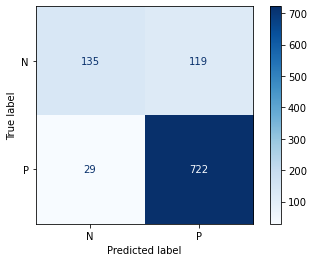

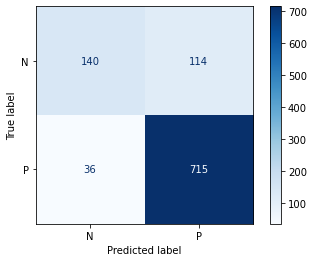

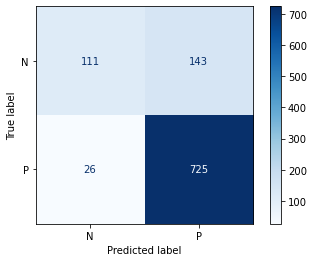

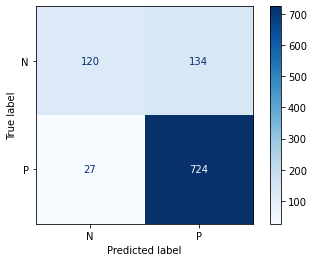

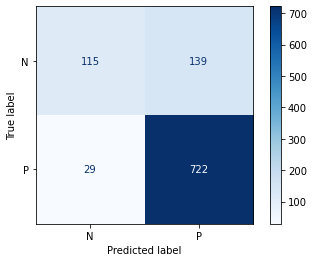

In [76]:
y_pred = []

for i in range(len(X_train_tfidf)):
    model = LogisticRegression()
    model.fit(X_train_tfidf[i], y_train[i])

    y_pred.append(model.predict(X_test_tfidf[i]))
    
    print("\nCombination "+str(i)+": "+combination_names[i])
    print(classification_report(y_test[i], y_pred[i], target_names=["N", "P"]))
    print(accuracy_score(y_test[i], y_pred[i]))
    print(confusion_matrix(y_test[i], y_pred[i]))
    plot_confusion_matrix(model, X_test_tfidf[i], y_test[i],
                                 display_labels=["N", "P"],
                                 cmap=plt.cm.Blues)
    
    with open('LogisticRegression_tfidf_'+combination_names[i].replace(', ', '_'), 'wb') as picklefile:
        pickle.dump(model, picklefile)

In [ ]:
# To save/load a model

with open('text_classifier', 'wb') as picklefile:
    pickle.dump(classifier, picklefile)
    
with open('text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)

###  b) Autre représentation pour l’analyse de sentiments et classification automatique

On vous propose maintenant d’utiliser une nouvelle représentation de chaque document à classifier.
Vous devez créer à partir de votre corpus la table suivante :

| Vocabulaire | Freq-positive | Freq-négative |
|-------------|---------------|---------------|
| happy | 10 | 1 |
| ... | ... | ... |

Où :

• Vocabulaire représente tous les types (mots uniques) de votre corpus d’entrainement

• Freq-positive : représente la somme des fréquences du mot dans tous les documents de la classe positive

• Freq-négative : représente la somme des fréquences du mot dans tous les documents de la classe négative

Notez qu’en Python, vous pouvez créer un dictionnaire associant à tout (mot, classe) une fréquence.
Ensuite il vous suffit de représenter chaque document par un vecteur à 3 dimensions dont le premier élément représente un biais (initialisé à 1), le deuxième élément représente la somme des fréquences positives (freq-pos) de tous les mots uniques (types) du document et enfin le troisième élément représente la somme des fréquences négative (freq-neg) de tous les mots uniques du document. 

En utilisant cette représentation ainsi que les pré-traitements suggérés, trouvez le meilleur modèle possible en testant la régression logistique et Naive Bayes. Vous ne devez fournir que le code de votre meilleur modèle dans votre notebook.

In [139]:
def calculFrequences(corpus: List[object]) -> object:
    dic = {}
    for doc in corpus: 
        sentiment = str(doc[2])
        for sentence in doc[1]: 
            for word in sentence.split():
                if word in dic:
                    dic[word][sentiment] += 1
                else:
                    dic_sent = {'True': 0, 'False': 0}
                    dic_sent[sentiment]  = 1
                    dic.setdefault(word, dic_sent)
    return dic

def representData1(freq: object) -> object:
    result = []
    for word in freq:
        result.append({"word" : word, "Freq-positive" : freq[word]["True"], "Freq-Negative":  freq[word]["False"]})

    dt = pd.DataFrame(result)
    dt.to_string(index=False)
    return dt

def representData2(freq: object, corpus: List[object]) -> object:
    result = []
    doc_index = 0
    for doc in corpus: 
        pos_freq = 0
        neg_freg = 0
        doc_index += 1
        for sentence in doc[1]: 
            for word in sentence.split():
                pos_freq += freq[word]["True"]
                neg_freg += freq[word]["False"]
        result.append([doc_index, pos_freq, neg_freg])
    return result

def getX(corpus: List[object]) -> object:
    freq = calculFrequences(corpus)
    display(representData1(freq))
    return representData2(freq, corpus)

In [140]:
X_train, y_train, X_test, y_test, X_train_others, X_test_others = [], [], [], [], [], []

for comb in range(len(combinations_result)):
    combination_name = combinations_result[comb][1]
    print("\nCombination "+str(comb)+": "+', '.join(combination_name))

    X_train = getX(combinations_result[comb][0])
    y_train.append([combinations_result[comb][0][i][2] for i in range(len(combinations_result[comb][0]))])

    X_test = getX(test_combinations_result[comb][0])
    y_test.append([test_combinations_result[comb][0][i][2] for i in range(len(test_combinations_result[comb][0]))])
    
    X_train_others.append(X_train)
    X_test_others.append(X_test)


Combination 0: lemmatize_doc


,word,Freq-positive,Freq-Negative
0,I,2716,682
1,don't,130,125
2,think,293,138
3,any,98,60
4,one,310,116
...,...,...,...
13150,1CSzjRf,1,0
13151,maxbeechcreative,1,0
13152,tireless,1,0
13153,appreicate,1,0


,word,Freq-positive,Freq-Negative
0,thanks,94,2
1,back,42,6
2,yep,1,0
3,university,1,1
4,of,162,81
...,...,...,...
3608,tingle,1,0
3609,ship,1,0
3610,fiber,1,0
3611,AND,2,0



Combination 1: stems_doc


,word,Freq-positive,Freq-Negative
0,i,2928,727
1,don't,130,125
2,think,256,112
3,ani,105,66
4,one,345,129
...,...,...,...
11216,1cszjrf,1,0
11217,maxbeechcr,1,0
11218,tireless,1,0
11219,appreic,1,0


,word,Freq-positive,Freq-Negative
0,thank,204,4
1,back,42,6
2,yep,1,0
3,univers,1,3
4,of,167,83
...,...,...,...
3278,msnbc,1,0
3279,tingl,1,0
3280,ship,1,0
3281,fiber,1,0



Combination 2: remove_stopwords_doc


,word,Freq-positive,Freq-Negative
0,I,2716,682
1,think,211,93
2,one,286,101
3,EBOLA,0,1
4,Bob,8,4
...,...,...,...
17403,1CSzjRf,1,0
17404,maxbeechcreative,1,0
17405,tireless,1,0
17406,appreicate,1,0


,word,Freq-positive,Freq-Negative
0,Thanks,67,1
1,back,41,6
2,Yep,1,0
3,University,1,0
4,Alberta,1,0
...,...,...,...
4306,tingles,1,0
4307,ship,1,0
4308,Something,1,0
4309,fiber,1,0



Combination 3: lemmatize_doc, remove_stopwords_doc


,word,Freq-positive,Freq-Negative
0,I,2716,682
1,think,293,138
2,one,310,116
3,ebola,0,3
4,bob,8,3
...,...,...,...
12518,1CSzjRf,1,0
12519,maxbeechcreative,1,0
12520,tireless,1,0
12521,appreicate,1,0


,word,Freq-positive,Freq-Negative
0,thanks,94,2
1,back,42,6
2,yep,1,0
3,university,1,1
4,alberta,1,0
...,...,...,...
3393,tingle,1,0
3394,ship,1,0
3395,fiber,1,0
3396,AND,2,0



Combination 4: stems_doc, remove_stopwords_doc


,word,Freq-positive,Freq-Negative
0,think,256,112
1,ani,105,66
2,one,345,129
3,ha,180,115
4,ebola,0,3
...,...,...,...
10621,1cszjrf,1,0
10622,maxbeechcr,1,0
10623,tireless,1,0
10624,appreic,1,0


,word,Freq-positive,Freq-Negative
0,thank,204,4
1,back,42,6
2,yep,1,0
3,univers,1,3
4,alberta,1,0
...,...,...,...
3081,msnbc,1,0
3082,tingl,1,0
3083,ship,1,0
3084,fiber,1,0


### Naive Bayes


Combination 0: lemmatize_doc
              precision    recall  f1-score   support

           N       0.29      0.47      0.36       254
           P       0.77      0.61      0.68       751

    accuracy                           0.58      1005
   macro avg       0.53      0.54      0.52      1005
weighted avg       0.65      0.58      0.60      1005

0.5771144278606966
[[119 135]
 [290 461]]

Combination 1: stems_doc
              precision    recall  f1-score   support

           N       0.30      0.46      0.37       254
           P       0.78      0.64      0.70       751

    accuracy                           0.60      1005
   macro avg       0.54      0.55      0.53      1005
weighted avg       0.66      0.60      0.62      1005

0.5950248756218905
[[118 136]
 [271 480]]

Combination 2: remove_stopwords_doc
              precision    recall  f1-score   support

           N       0.30      0.69      0.42       254
           P       0.82      0.46      0.59       751

    a

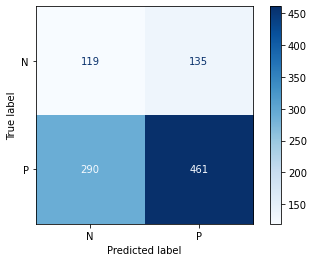

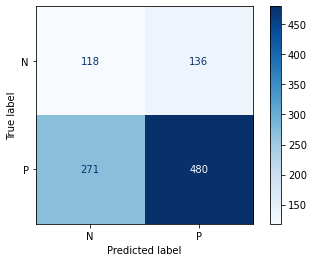

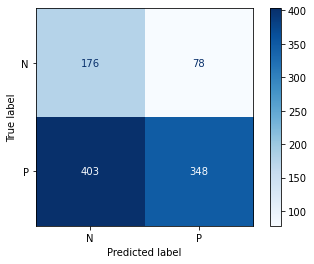

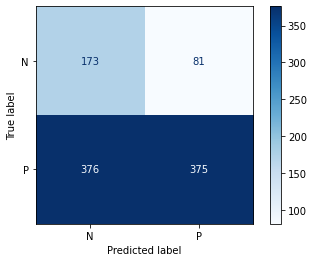

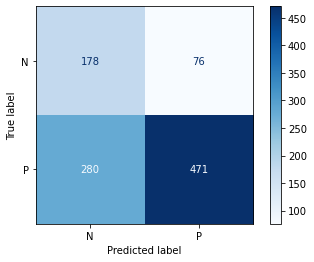

In [142]:
y_pred = []

for i in range(len(X_train_tfidf)):
    model = MultinomialNB()
    model.fit(X_train_others[i], y_train[i])

    y_pred.append(model.predict(X_test_others[i]))
    
    print("\nCombination "+str(i)+": "+combination_names[i])
    print(classification_report(y_test[i], y_pred[i], target_names=["N", "P"]))
    print(accuracy_score(y_test[i], y_pred[i]))
    print(confusion_matrix(y_test[i], y_pred[i]))
    plot_confusion_matrix(model, X_test_others[i], y_test[i],
                                 display_labels=["N", "P"],
                                 cmap=plt.cm.Blues)
    
    with open('NaiveBayes_freq_'+combination_names[i].replace(', ', '_'), 'wb') as picklefile:
        pickle.dump(model, picklefile)

### Régression Logistique


Combination 0: lemmatize_doc
              precision    recall  f1-score   support

           N       0.67      0.32      0.44       254
           P       0.80      0.95      0.87       751

    accuracy                           0.79      1005
   macro avg       0.74      0.63      0.65      1005
weighted avg       0.77      0.79      0.76      1005

0.7880597014925373
[[ 82 172]
 [ 41 710]]

Combination 1: stems_doc
              precision    recall  f1-score   support

           N       0.00      0.00      0.00       254
           P       0.75      1.00      0.86       751

    accuracy                           0.75      1005
   macro avg       0.37      0.50      0.43      1005
weighted avg       0.56      0.75      0.64      1005

0.7472636815920398
[[  0 254]
 [  0 751]]

Combination 2: remove_stopwords_doc

C:\Users\oumay\Anaconda3\envs\inf8460\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

           N       0.00      0.00      0.00       254
           P       0.75      1.00      0.86       751

    accuracy                           0.75      1005
   macro avg       0.37      0.50      0.43      1005
weighted avg       0.56      0.75      0.64      1005

0.7472636815920398
[[  0 254]
 [  0 751]]

Combination 3: lemmatize_doc, remove_stopwords_doc

C:\Users\oumay\Anaconda3\envs\inf8460\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

           N       0.00      0.00      0.00       254
           P       0.75      1.00      0.86       751

    accuracy                           0.75      1005
   macro avg       0.37      0.50      0.43      1005
weighted avg       0.56      0.75      0.64      1005

0.7472636815920398
[[  0 254]
 [  0 751]]

Combination 4: stems_doc, remove_stopwords_doc

C:\Users\oumay\Anaconda3\envs\inf8460\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

           N       1.00      0.01      0.02       254
           P       0.75      1.00      0.86       751

    accuracy                           0.75      1005
   macro avg       0.87      0.50      0.44      1005
weighted avg       0.81      0.75      0.64      1005

0.7492537313432835
[[  2 252]
 [  0 751]]


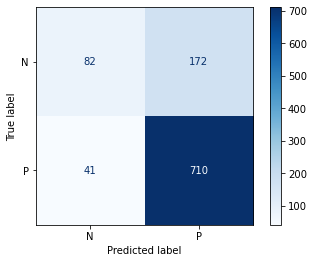

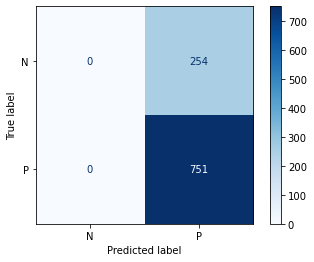

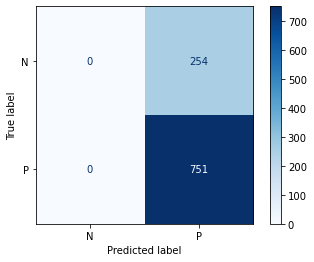

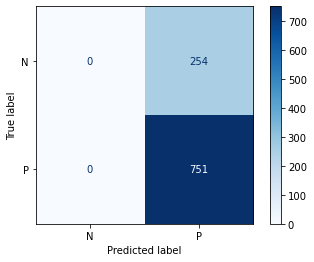

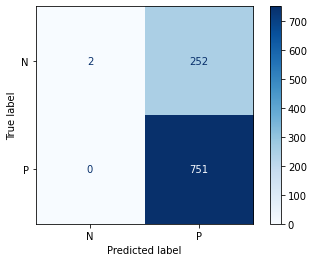

In [144]:
y_pred = []

for i in range(len(X_train_others)):
    model = LogisticRegression()
    model.fit(X_train_others[i], y_train[i])

    y_pred.append(model.predict(X_test_others[i]))
    
    print("\nCombination "+str(i)+": "+combination_names[i])
    print(classification_report(y_test[i], y_pred[i], target_names=["N", "P"]))
    print(accuracy_score(y_test[i], y_pred[i]))
    print(confusion_matrix(y_test[i], y_pred[i]))
    plot_confusion_matrix(model, X_test_others[i], y_test[i],
                                 display_labels=["N", "P"],
                                 cmap=plt.cm.Blues)
    
    with open('LogisticRegression_freq_'+combination_names[i].replace(', ', '_'), 'wb') as picklefile:
        pickle.dump(model, picklefile)

## 3. Évaluation et discussion

#### a) Pour déterminer la performance de vos modèles, vous devez tester vos modèles de classification sur l’ensemble de test et générer vos résultats pour chaque modèle dans une table avec les métriques suivantes : Accuracy et pour chaque classe, la précision, le rappel et le F1 score. On doit voir cette table générée dans votre notebook avec la liste de vos modèles de la section 2 et leurs performances respectives. 

#### b) Générez un graphique qui représente la performance moyenne (mean accuracy – 10 Fold cross-validation) de vos différents modèles par tranches de 500 textes sur l’ensemble d’entrainement.

In [145]:
random.seed()
scores_NB, scores_LR, scores_NB_others, scores_LR_others = [], [], [], []
  
# tfidf
for i in range(len(combination_names)):
    samples = random.choices([[X_train_tfidf[comb][i], y_train[comb][i]] for i in range(len(X_train_tfidf[comb]))], k=5000)
    
    model = MultinomialNB()
    scores_NB.append(cross_val_score(model, [samples[i][0] for i in range(len(samples))], [samples[i][1] for i in range(len(samples))], cv=10))
    
    model = LogisticRegression()
    scores_LR.append(cross_val_score(model, [samples[i][0] for i in range(len(samples))], [samples[i][1] for i in range(len(samples))], cv=10))
    
# freq
for i in range(len(combination_names)):
    samples = random.choices([[X_train_others[comb][i], y_train[comb][i]] for i in range(len(X_train_others[comb]))], k=5000)
    
    model = MultinomialNB()
    scores_NB_others.append(cross_val_score(model, [samples[i][0] for i in range(len(samples))], [samples[i][1] for i in range(len(samples))], cv=10))
    
    model = LogisticRegression()
    scores_LR_others.append(cross_val_score(model, [samples[i][0] for i in range(len(samples))], [samples[i][1] for i in range(len(samples))], cv=10))
    
    
print(scores_NB)
print(scores_LR)
print(scores_NB_others)
print(scores_LR_others)

[array([0.78 , 0.798, 0.782, 0.782, 0.782, 0.788, 0.8  , 0.792, 0.784,
       0.784]), array([0.778, 0.784, 0.778, 0.782, 0.79 , 0.776, 0.776, 0.78 , 0.778,
       0.784]), array([0.792, 0.786, 0.784, 0.794, 0.8  , 0.808, 0.786, 0.786, 0.774,
       0.79 ]), array([0.792, 0.794, 0.794, 0.798, 0.794, 0.786, 0.802, 0.782, 0.802,
       0.784]), array([0.782, 0.784, 0.824, 0.782, 0.794, 0.786, 0.786, 0.78 , 0.804,
       0.782])]
[array([0.81 , 0.834, 0.812, 0.824, 0.83 , 0.832, 0.834, 0.84 , 0.818,
       0.824]), array([0.826, 0.82 , 0.82 , 0.82 , 0.834, 0.838, 0.832, 0.822, 0.826,
       0.836]), array([0.84 , 0.836, 0.828, 0.818, 0.842, 0.83 , 0.83 , 0.826, 0.824,
       0.848]), array([0.844, 0.836, 0.828, 0.836, 0.848, 0.832, 0.824, 0.824, 0.852,
       0.824]), array([0.822, 0.82 , 0.87 , 0.83 , 0.844, 0.824, 0.834, 0.836, 0.846,
       0.828])]
[array([0.57 , 0.604, 0.554, 0.566, 0.608, 0.566, 0.588, 0.58 , 0.58 ,
       0.612]), array([0.58 , 0.542, 0.578, 0.546, 0.608, 0.576, 0.

In [153]:
combination_names = ['lemmatize_doc', 'stems_doc', 'remove_stopwords_doc', 'lemmatize_doc, remove_stopwords_doc', 'stems_doc, remove_stopwords_doc']

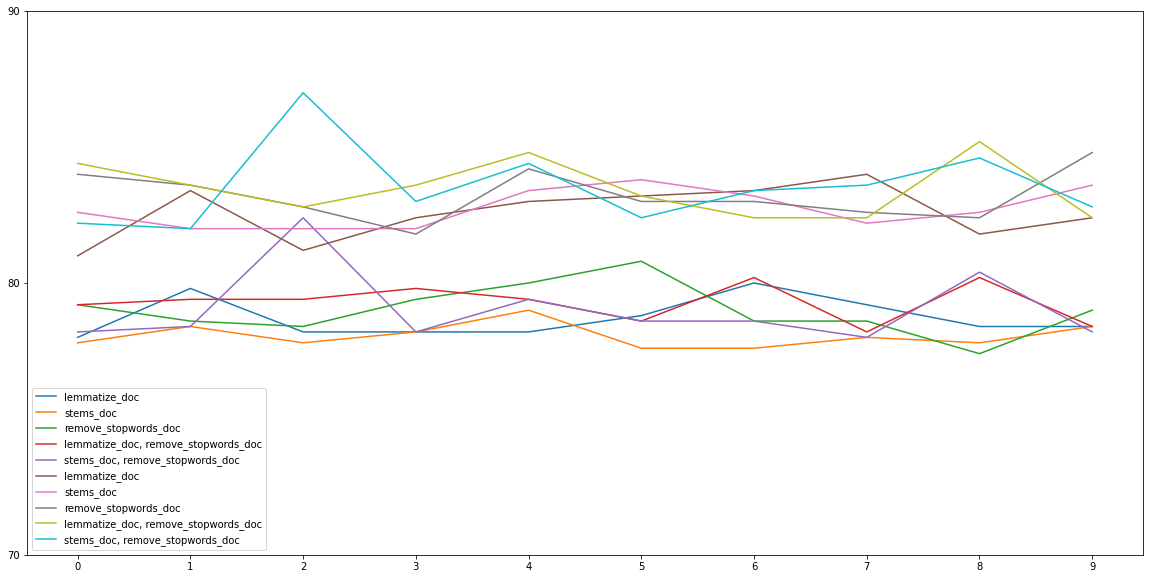

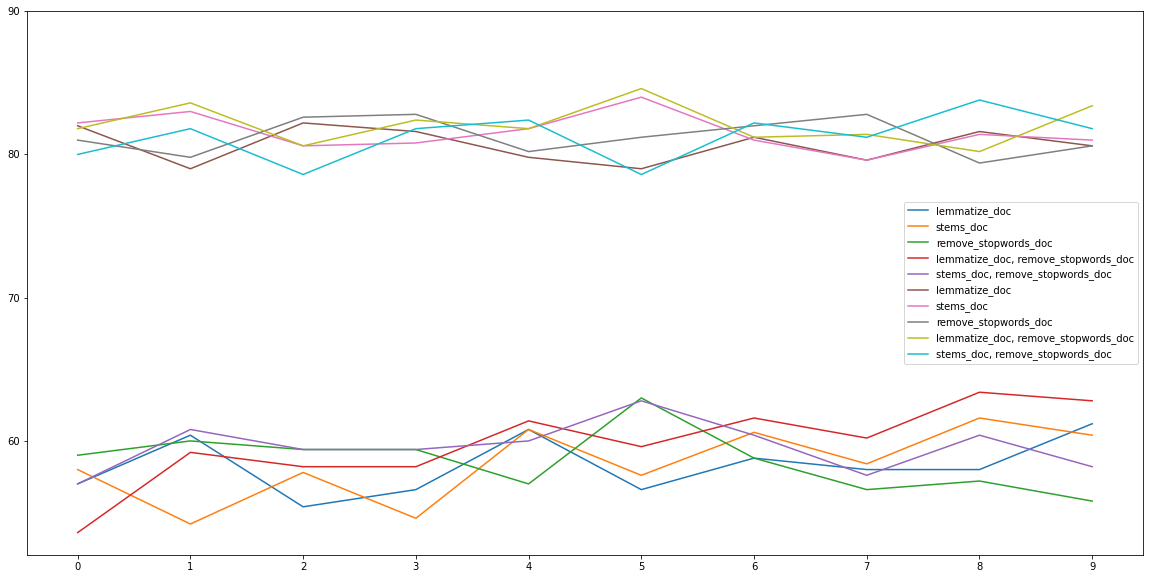

In [158]:
# tfidf
plt.figure(figsize=(20, 10))
for i in range(len(combination_names)):
    plt.plot(scores_NB[i]*100)
for i in range(len(combination_names)):
    plt.plot(scores_LR[i]*100)
plt.xticks([x for x in range(0, 10)])
plt.yticks([x for x in range(70, 100, 10)])
plt.legend(combination_names+combination_names)
plt.show()

# freq
plt.figure(figsize=(20, 10))
for i in range(len(combination_names)):
    plt.plot(scores_NB_others[i]*100)
for i in range(len(combination_names)):
    plt.plot(scores_LR_others[i]*100)
plt.xticks([x for x in range(0, 10)])
plt.yticks([x for x in range(60, 100, 10)])
plt.legend(combination_names+combination_names)
plt.show()

#### c) Que se passe-t-il lorsque le paramètre de régularisation de la régression logisque (C) est augmenté ?

In [ ]:
i = 3

model = LogisticRegression(C = )
model.fit(X_train_others[i], y_train[i])

y_pred.append(model.predict(X_test_others[i]))

print("\nCombination "+str(i)+": "+combination_names[i])
print(classification_report(y_test[i], y_pred[i], target_names=["N", "P"]))
print(accuracy_score(y_test[i], y_pred[i]))
print(confusion_matrix(y_test[i], y_pred[i]))
plot_confusion_matrix(model, X_test_others[i], y_test[i],
                             display_labels=["N", "P"],
                             cmap=plt.cm.Blues)

## 4. Analyse et discussion

#### a) En considérant les deux types de représentations, répondez aux question suivantes en reportant la question dans le notebook et en inscrivant votre réponse:

#### b) Quel est l’impact de l’annotation de la négation ?

#### c) La suppression des stopwords est-elle une bonne idée pour l’analyse de sentiments ?

#### d) Le stemming et/ou la lemmatisation sont-ils souhaitables dans le cadre de l’analyse de sentiments ?

## 5. Contribution

Complétez la section en haut du notebook indiquant la contribution de chaque membre de l’équipe en indiquant ce qui a été effectué par chaque membre et le pourcentage d’effort du membre dans le TP. 